<a href="https://colab.research.google.com/github/BenYavor/Autoencoder_communication_system_WGAN_Channel-estimation/blob/master/Communication_Autoencoder_with_WGAN_and_pre_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import sys
assert sys.version_info >= (3, 5)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special
#from Clustering_Equalgrps.equal_groups import EqualGroupsKMeans
from tensorflow.keras import layers
np.random.seed(42)
tf.random.set_seed(42)

#### Vergleich
Als erstes für feste $k$ und $n$, was sich ändert ist die Samplesize, Anzahl der Samples und SNR

###Systemparameter
ACHTUNG: CHANNELANZAHL WURDE UNTERSCHIEDLICH VERWENDET \\
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses\\
$N$ - Länge des Rauschvektors

In [2]:
k = 4      # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2    # Number of real channel uses per message
#k = int(np.log2(M))
#n = 2
print(M)

SNR = 7


16


## Training Parameter

In [0]:
gen_learning_rate=5e-5
disc_learning_rate = 5e-5                 # 0.0001  

### Different Layers

In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

EncIn = tf.keras.layers.Input(shape=(M,))#, dtype= tf.int32)
e1 = tf.keras.layers.Dense(2*n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
# = tf.keras.layers.Lambda(generator)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')


#noise_std = EbNo_to_noise(TRAINING_SNR)
# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,n]))
channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

### Help functions

In [5]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(2*k/n)*ebno) 
    return noise_std


def real_channel(x,noise_std):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

def rayleigh_channel(x,noise_std):
    return x + tf.sqrt(tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def random_sample(batch_size=32):
    msg = np.random.randint(M, size=batch_size)
    return msg




def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(input_msg, tf.argmax(msg, 1))      
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

noise_std = EbNo2Sigma(SNR)

print(EbNo2Sigma(SNR))
print(EbNo_to_noise(SNR))

0.15792649852735607
0.15792649852735607


In [0]:
def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = gan_encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()


def test_encoding_pre(M=16, n=1):
    inp = np.arange(0,M)
    coding = pre_encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()    


# Models

#### Generator Model

In [0]:
def get_generator(n):
  input1 = tf.keras.layers.Input(shape=(n,))
  x1 = tf.keras.layers.Dense(n)(input1)
  input2 =tf.random.normal(shape=tf.shape(input1))
  #input2 =tf.random.normal([tf.shape(input1)[0],n])
  x2 = tf.keras.layers.Dense(n)(input2)
  subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
  h1 = tf.keras.layers.Dense(64,use_bias=True,  activation='relu')(subtracted)
  h2 = tf.keras.layers.Dense(64,use_bias=True, activation='relu')(h1)
  out = tf.keras.layers.Dense(n, use_bias= True, activation='linear')(h2)
  generator = tf.keras.models.Model(inputs=[input1], outputs=out)
  return generator

#### Discriminator Model 

In [0]:
def get_discriminator(n):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=False, kernel_initializer=randN_initial,activation='relu',input_shape=((2*n,))))
  model.add(tf.keras.layers.Dense(32,use_bias=False, kernel_initializer=randN_initial, activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False, activation='linear'))
  return model

number_of_disc_layers = 3

In [0]:
generator = get_generator(n)
discriminator = get_discriminator(n)

## Encoder and Pre-Encoder Model

In [0]:
def get_gan_encoder(M):
  model = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M*2, activation="elu"),
            keras.layers.Dense(M*2, activation="elu"),
            keras.layers.Dense(n, activation=None),
            e2,
            EncOut,
            GenIn])
  return model

def get_pre_encoder(M):
  model = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M,kernel_initializer=randN_initial, activation="elu"),
            keras.layers.Dense(n,kernel_initializer=randN_initial, activation=None),
            e2,
            EncOut,
            GenIn])
  return model

## Decoder and Pre-Decoder Model

In [0]:
def get_gan_decoder(M):
   model= keras.models.Sequential([
                #DecIn,
                #d1,
                keras.layers.Input(shape=(n,)),
                keras.layers.Dense(M*2, activation="elu"),
                keras.layers.Dense(M*2, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])
   return model


def get_pre_decoder(M):
   model= keras.models.Sequential([
                #DecIn,
                #d1,
                keras.layers.Input(shape=(n,)),
                keras.layers.Dense(M,kernel_initializer=randN_initial, activation="elu"),
                keras.layers.Dense(M,kernel_initializer=randN_initial, activation="softmax")
                ])
   return model


In [0]:
def compute_loss(batch_size):
  m =random_sample(batch_size)
  r = pre_encoder(m)
  real_training_data = tf.concat(values=[real_channel(r,noise_std), r], axis=1)
  fake_training_data = tf.concat(values=[generator(r),r], axis=1)
  real_output = discriminator(real_training_data)
  fake_output = discriminator(fake_training_data)
  disc_loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)
  gen_loss = -tf.reduce_mean(fake_output)

  return disc_loss, gen_loss

### GAN Training functions

In [0]:
def gan_optimizers(gen_learning_rate  ,disc_learning_rate):
  generator_optimizer = tf.keras.optimizers.RMSprop(gen_learning_rate)      #RMSprop   in oreder to test where the error comes from
  discriminator_optimizer = tf.keras.optimizers.RMSprop(disc_learning_rate) 
  return generator_optimizer, discriminator_optimizer

In [14]:
%%time
def train_gan(epochs,n_steps, batch_size, SNR_level):
  noise_std = EbNo2Sigma(SNR_level)
  start = time.time()
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32) 
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  counter = 0
  epoch = 0
  loss = []
  for epoch in range(epochs):
    counter += 1
    lossess=train_step(noise_std, n_steps,batch_size)
    if epoch%500 == 0:
      real_c = tf.concat(values=[real_channel(x,noise_std), x], axis=1)
      fake_c = generator(x)
      real_eval_data, fake_eval_data, inputs = get_evaluation_data()
      test_eval(real_eval_data, fake_eval_data, inputs)
      tf.print(fake_c[0])
      #tf.print(disc_loss, gen_loss)
    loss.append(compute_loss(batch_size))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    if counter%100==0:
      tf.print("counter %d:" % (counter))
      fake_c = generator(x)
      tf.print(fake_c[0])
      print(
         "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
              epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]))
    #print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))

      
  tf.saved_model.save(generator,'/tmp/saved_model/')
  tf.print ('Time for the training is {} sec,'.format( time.time()-start))
  plt.plot(losses.disc_loss.values)  

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


In [0]:
@tf.function
def train_step(noise_std,n_steps,batch_size):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32) 
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  m =random_sample(batch_size)
  r = pre_encoder(m)
  for i in range(n_steps):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      real_training_data = tf.concat(values=[real_channel(r,noise_std), r], axis=1)
      fake_training_data = tf.concat(values=[generator(r),r], axis=1)
      real_output = discriminator(real_training_data)
      fake_output = discriminator(fake_training_data)
      
      
      #disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))
      #gen_loss =-tf.reduce_mean(tf.math.log(fake_output))
      
      disc_loss = -tf.reduce_mean(real_output) + tf.reduce_mean(fake_output)

      #tf.print(disc_loss,gen_loss)
      
      if tf.math.is_nan(disc_loss) == False:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        t=0
        for t in range(number_of_disc_layers):
          y = tf.clip_by_value(discriminator.trainable_weights[t],clip_value_min=-0.01,clip_value_max=0.01,name=None)
          discriminator.trainable_weights[t].assign(y)

        #tf.print(discriminator.trainable_weights[1])

    
      if i == 4:
        fake_training_data = tf.concat(values=[generator(r),r], axis=1)
        fake_output = discriminator(fake_training_data)
        gen_loss = -tf.reduce_mean(fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



In [0]:
def creating_and_train_gan(epochs,n_steps, batch_size, SNR_level , n ):  #optional Leraning Rates
  train_gan(epochs, n_steps, batch_size, SNR_level)
  #4 after GAN training
  generator.trainable = False
  tf.print(generator.trainable)

In [0]:
def gan_Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = gan_encoder(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = gan_decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)

def Test_AE_rayleigh(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = gan_encoder(data)
        rcvd_word = rayleigh_channel(code_word, noise_std)
        dcoded_msg = gan_decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)


In [0]:
def generate_evaluation_data(batch_size=100):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
  fake_eval_data = generator([x])
  real_eval_data = real_channel(x,noise_std) #tf.concat(values=[real_channel(x),x], axis=1)
  inputs = x
  return  real_eval_data, fake_eval_data, inputs 



def get_evaluation_data(evaluation_per_epochs=100):
  real_eval_data = []
  fake_eval_data  = []
  inputs = []
  for i in range(evaluation_per_epochs):
    data = generate_evaluation_data()
    real_eval_data.append(data[0])
    fake_eval_data.append(data[1])
    inputs.append(data[2])
  return real_eval_data, fake_eval_data, inputs


def test_eval(real_eval_data,fake_eval_data,inputs):
  hist_range = 1
  
  
  fake_output_hist = np.mean(fake_eval_data,axis=0)  # Changed from 0 to 1
  real_output_hist = np.mean(real_eval_data,axis=0)
  inputs_hist = np.mean(inputs,axis=0)
    
  fake_output_hist1 = np.reshape( fake_output_hist,[-1,])
  real_output_hist1 = np.reshape( real_output_hist,[-1,])
    
  plt.hist(fake_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution")
  plt.legend(["generator", "target"])
  plt.show()

# Pre Autoencoder Training

Train on 10000000 samples
Epoch 1/5
  194000/10000000 [..............................] - ETA: 54s - loss: 0.0024 - accuracy: 1.0000Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, None)              562       
_________________________________________________________________
sequential_1 (Sequential)    (None, 16)                320       
Total params: 882
Trainable params: 882
Non-trainable params: 0
_________________________________________________________________


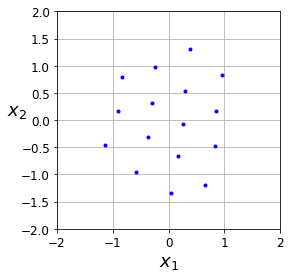

(10000000,)
(10000000, 2)


In [19]:
pre_decoder = get_pre_decoder(M)
pre_encoder = get_pre_encoder(M)



gan_AE = tf.keras.models.Sequential([pre_encoder,pre_decoder])
data, test_data = random_sample(10000000), random_sample(10000)
start = time.time()
gan_AE.compile(optimizer=keras.optimizers.Nadam(lr=0.005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=500,steps_per_epoch=400, epochs=5)
#pre_encoder.trainable = False
#pre_decoder.trainable = False
gan_AE.summary() 
test_encoding_pre(M,n) 

print(data.shape)
print(pre_encoder(data).shape)

# GAN Training

In [0]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

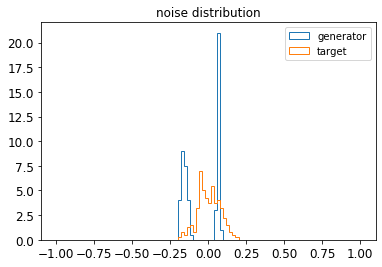

[0.0734806 -0.0499599725]
counter 100:
[-0.00121649727 -0.245382577]
Epoch: 99 | disc_loss: 0.00011905699648195878 | gen_loss: 7.876027666497976e-06
counter 200:
[-0.0744447 -0.100152157]
Epoch: 199 | disc_loss: 0.00018150651885662228 | gen_loss: 1.0958960956486408e-05
counter 300:
[-0.146361113 -0.171890408]
Epoch: 299 | disc_loss: 0.00019369882647879422 | gen_loss: 1.8379257653577952e-06
counter 400:
[-0.278961807 -0.222525254]
Epoch: 399 | disc_loss: 0.00019471820269245654 | gen_loss: -1.1598353921726812e-05
counter 500:
[-0.301209718 -0.351020277]
Epoch: 499 | disc_loss: 0.00019407198124099523 | gen_loss: -1.6238685930147767e-05


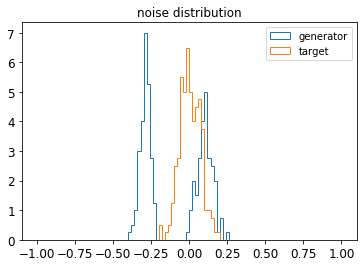

[-0.423606 -0.415723115]
counter 600:
[-0.714854836 -0.841966927]
Epoch: 599 | disc_loss: 0.00019485937082208693 | gen_loss: -2.0402132577146403e-05
counter 700:
[0.163548455 -0.393101692]
Epoch: 699 | disc_loss: 0.00019676715601235628 | gen_loss: -2.1325920897652395e-05
counter 800:
[0.71594137 -0.184789568]
Epoch: 799 | disc_loss: 0.00019727673497982323 | gen_loss: -2.312913056812249e-05
counter 900:
[1.1566627 0.0319847427]
Epoch: 899 | disc_loss: 0.00019851325487252325 | gen_loss: -2.296567618031986e-05
counter 1000:
[-0.0674154 -0.765126348]
Epoch: 999 | disc_loss: 0.00019949710986111313 | gen_loss: -2.377633427386172e-05


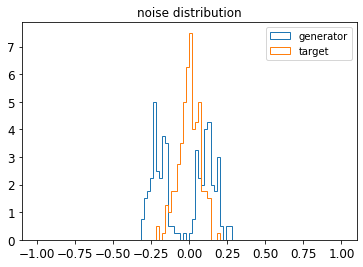

[0.219692364 -0.589501798]
counter 1100:
[0.728639543 -0.35848847]
Epoch: 1099 | disc_loss: 0.0001996575592784211 | gen_loss: -2.4923927412601188e-05
counter 1200:
[0.882521033 -0.37281093]
Epoch: 1199 | disc_loss: 0.00019871727272402495 | gen_loss: -2.6385994715383276e-05
counter 1300:
[0.780696213 -0.461184114]
Epoch: 1299 | disc_loss: 0.00019761697330977768 | gen_loss: -2.7382257030694745e-05
counter 1400:
[0.872748494 -0.444488823]
Epoch: 1399 | disc_loss: 0.0001956382329808548 | gen_loss: -2.891420263040345e-05
counter 1500:
[-0.0567956045 -0.557433665]
Epoch: 1499 | disc_loss: 0.00019321159925311804 | gen_loss: -3.1208644941216335e-05


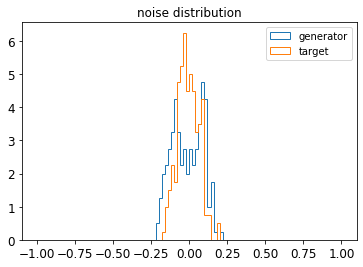

[0.969752848 -0.286844641]
counter 1600:
[0.824841738 -0.332006097]
Epoch: 1599 | disc_loss: 0.0001902376679936424 | gen_loss: -3.438932981225662e-05
counter 1700:
[0.178326339 -0.566003561]
Epoch: 1699 | disc_loss: 0.0001861479686340317 | gen_loss: -3.756482692551799e-05
counter 1800:
[0.54889065 -0.556053281]
Epoch: 1799 | disc_loss: 0.00018143483612220734 | gen_loss: -4.104251638636924e-05
counter 1900:
[0.382312953 -0.5632447]
Epoch: 1899 | disc_loss: 0.00017568108160048723 | gen_loss: -4.4669963244814426e-05
counter 2000:
[0.722467542 -0.459784448]
Epoch: 1999 | disc_loss: 0.0001690125063760206 | gen_loss: -4.852504571317695e-05


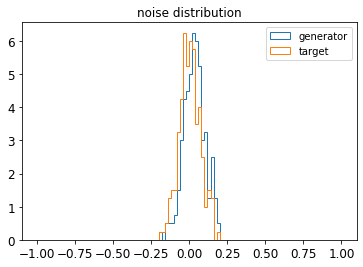

[0.749677777 -0.447780102]
counter 2100:
[0.599526 -0.518554747]
Epoch: 2099 | disc_loss: 0.00016172032337635756 | gen_loss: -5.21009205840528e-05
counter 2200:
[0.454918414 -0.489253968]
Epoch: 2199 | disc_loss: 0.00015483936294913292 | gen_loss: -5.510783739737235e-05
counter 2300:
[0.346705258 -0.283764154]
Epoch: 2299 | disc_loss: 0.00014829834981355816 | gen_loss: -5.4607546189799905e-05
counter 2400:
[0.566354156 -0.507176578]
Epoch: 2399 | disc_loss: 0.000142151111504063 | gen_loss: -5.272623093333095e-05
counter 2500:
[0.626316845 -0.293927133]
Epoch: 2499 | disc_loss: 0.00013651193876285106 | gen_loss: -4.9600439524510875e-05


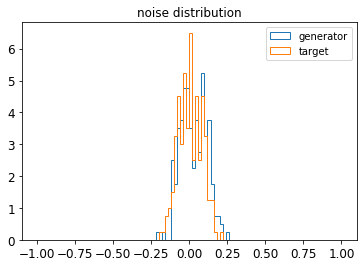

[0.651569426 -0.536736727]
counter 2600:
[0.800199866 -0.298218161]
Epoch: 2599 | disc_loss: 0.00013137416681274772 | gen_loss: -4.6961813495727256e-05
counter 2700:
[0.729599118 -0.392956287]
Epoch: 2699 | disc_loss: 0.0001267202605959028 | gen_loss: -4.4559510570252314e-05
counter 2800:
[0.69516778 -0.5052827]
Epoch: 2799 | disc_loss: 0.00012228429841343313 | gen_loss: -4.277097832527943e-05
counter 2900:
[0.604207039 -0.606674314]
Epoch: 2899 | disc_loss: 0.00011817401536973193 | gen_loss: -4.227694807923399e-05
counter 3000:
[0.682241857 -0.601755857]
Epoch: 2999 | disc_loss: 0.00011428648576838896 | gen_loss: -4.2322848457843065e-05


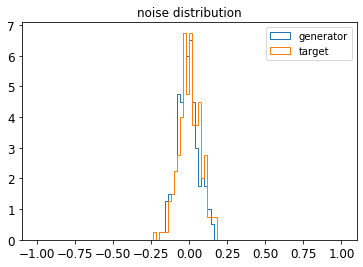

[0.678183377 -0.333485305]
counter 3100:
[0.63090229 -0.486999273]
Epoch: 3099 | disc_loss: 0.0001106562340282835 | gen_loss: -4.227022873237729e-05
counter 3200:
[0.379291922 -0.536185205]
Epoch: 3199 | disc_loss: 0.000107257925265003 | gen_loss: -4.191314656054601e-05
counter 3300:
[0.655409694 -0.438856304]
Epoch: 3299 | disc_loss: 0.0001040787756210193 | gen_loss: -4.131849345867522e-05
counter 3400:
[0.743575633 -0.45811981]
Epoch: 3399 | disc_loss: 0.00010108888818649575 | gen_loss: -4.0100887417793274e-05
counter 3500:
[0.683207691 -0.439942718]
Epoch: 3499 | disc_loss: 9.829976625042036e-05 | gen_loss: -3.901062154909596e-05


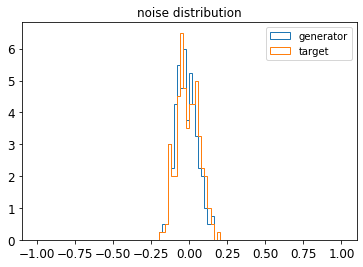

[0.698371768 -0.393224478]
counter 3600:
[0.759799063 -0.392145723]
Epoch: 3599 | disc_loss: 9.567499364493415e-05 | gen_loss: -3.792794086621143e-05
counter 3700:
[0.80371356 -0.377567887]
Epoch: 3699 | disc_loss: 9.316707291873172e-05 | gen_loss: -3.70444540749304e-05
counter 3800:
[0.510917723 -0.250097513]
Epoch: 3799 | disc_loss: 9.079400479095057e-05 | gen_loss: -3.5861907235812396e-05
counter 3900:
[0.673703194 -0.3780002]
Epoch: 3899 | disc_loss: 8.852744213072583e-05 | gen_loss: -3.449841096880846e-05
counter 4000:
[0.415212214 -1.04548109]
Epoch: 3999 | disc_loss: 8.634320693090558e-05 | gen_loss: -3.348557584104128e-05


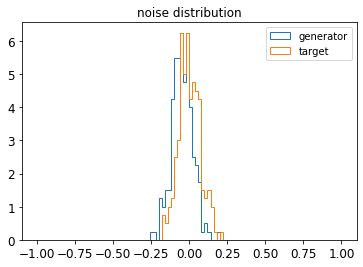

[0.663159907 -0.213115185]
counter 4100:
[0.46837911 -0.757702172]
Epoch: 4099 | disc_loss: 8.425113628618419e-05 | gen_loss: -3.2702784665161744e-05
counter 4200:
[0.691087186 -0.256161]
Epoch: 4199 | disc_loss: 8.226814679801464e-05 | gen_loss: -3.1871746614342555e-05
counter 4300:
[0.515649378 -0.361679047]
Epoch: 4299 | disc_loss: 8.038892701733857e-05 | gen_loss: -3.107750308117829e-05
counter 4400:
[0.741629481 -0.26575774]
Epoch: 4399 | disc_loss: 7.860144978621975e-05 | gen_loss: -3.033139910257887e-05
counter 4500:
[0.735863805 -0.273425072]
Epoch: 4499 | disc_loss: 7.689248013775796e-05 | gen_loss: -2.9916285711806267e-05


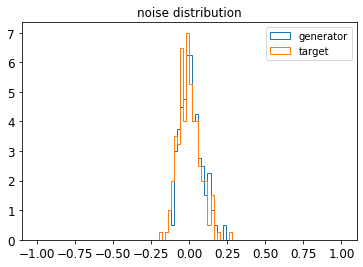

[0.57180208 -0.638479233]
counter 4600:
[0.546602 -0.58279562]
Epoch: 4599 | disc_loss: 7.524628017563373e-05 | gen_loss: -2.951557507913094e-05
counter 4700:
[0.714027107 -0.189344496]
Epoch: 4699 | disc_loss: 7.36708243493922e-05 | gen_loss: -2.8747181204380468e-05
counter 4800:
[0.502280414 -0.71548748]
Epoch: 4799 | disc_loss: 7.215690857265145e-05 | gen_loss: -2.8081673008273356e-05
counter 4900:
[0.745167 -0.271593362]
Epoch: 4899 | disc_loss: 7.070785795804113e-05 | gen_loss: -2.7486476028570905e-05
counter 5000:
[0.406502426 -0.597320676]
Epoch: 4999 | disc_loss: 6.93221008987166e-05 | gen_loss: -2.695977673283778e-05


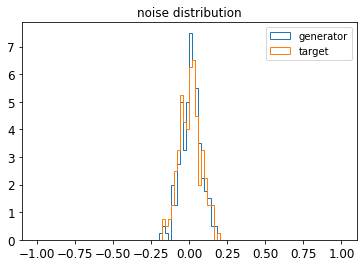

[0.562036872 -0.273141026]
counter 5100:
[0.590287626 -0.340128392]
Epoch: 5099 | disc_loss: 6.799326365580782e-05 | gen_loss: -2.6189112759311683e-05
counter 5200:
[0.562436163 -0.52744472]
Epoch: 5199 | disc_loss: 6.671260780422017e-05 | gen_loss: -2.5285531592089683e-05
counter 5300:
[0.702727795 -0.324253142]
Epoch: 5299 | disc_loss: 6.547432712977752e-05 | gen_loss: -2.4411960112047382e-05
counter 5400:
[0.442275167 -0.273389459]
Epoch: 5399 | disc_loss: 6.427715561585501e-05 | gen_loss: -2.3459966541850008e-05
counter 5500:
[0.740640402 -0.252879977]
Epoch: 5499 | disc_loss: 6.312529876595363e-05 | gen_loss: -2.2537127733812667e-05


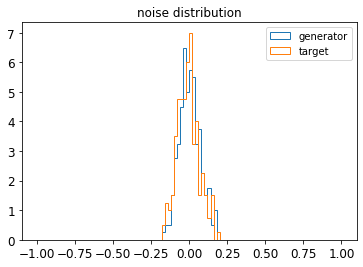

[0.681006193 -0.425636053]
counter 5600:
[0.545066774 -0.322386086]
Epoch: 5599 | disc_loss: 6.200774805620313e-05 | gen_loss: -2.175027839257382e-05
counter 5700:
[0.697301149 -0.373535246]
Epoch: 5699 | disc_loss: 6.092904368415475e-05 | gen_loss: -2.08437122637406e-05
counter 5800:
[0.626652539 -0.517958164]
Epoch: 5799 | disc_loss: 5.98869810346514e-05 | gen_loss: -2.007261173275765e-05
counter 5900:
[0.720631123 -0.507587254]
Epoch: 5899 | disc_loss: 5.8878194977296516e-05 | gen_loss: -1.9256605810369365e-05
counter 6000:
[0.636101305 -0.266724139]
Epoch: 5999 | disc_loss: 5.790198338218033e-05 | gen_loss: -1.840332151914481e-05


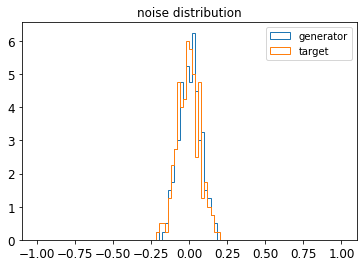

[0.677700102 -0.3477256]
counter 6100:
[0.390831441 -0.171237931]
Epoch: 6099 | disc_loss: 5.6960714573506266e-05 | gen_loss: -1.771193274180405e-05
counter 6200:
[0.711648285 -0.379641831]
Epoch: 6199 | disc_loss: 5.6046737881843e-05 | gen_loss: -1.692625846771989e-05
counter 6300:
[0.696616411 -0.381002933]
Epoch: 6299 | disc_loss: 5.516386227100156e-05 | gen_loss: -1.617469752090983e-05
counter 6400:
[0.415728629 -0.569577098]
Epoch: 6399 | disc_loss: 5.430804958450608e-05 | gen_loss: -1.537881871627178e-05
counter 6500:
[0.417210966 -0.714649498]
Epoch: 6499 | disc_loss: 5.348049307940528e-05 | gen_loss: -1.4671541066491045e-05


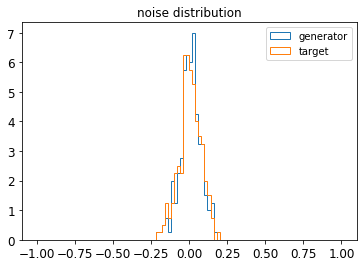

[0.549634099 -0.675857902]
counter 6600:
[0.448293477 -0.233469516]
Epoch: 6599 | disc_loss: 5.2674793550977483e-05 | gen_loss: -1.4014230146131013e-05
counter 6700:
[0.66110903 -0.520334959]
Epoch: 6699 | disc_loss: 5.189389412407763e-05 | gen_loss: -1.341385632258607e-05
counter 6800:
[0.655693054 -0.540529609]
Epoch: 6799 | disc_loss: 5.1138409617124125e-05 | gen_loss: -1.2874567801191006e-05
counter 6900:
[0.74775368 -0.279927075]
Epoch: 6899 | disc_loss: 5.040587711846456e-05 | gen_loss: -1.2306451026233844e-05
counter 7000:
[0.550244033 -0.480345398]
Epoch: 6999 | disc_loss: 4.969010115019046e-05 | gen_loss: -1.1826758964161854e-05


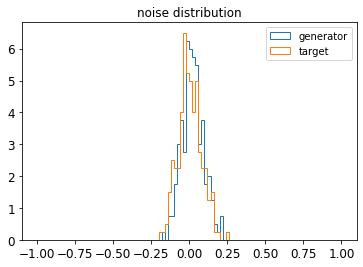

[0.893302739 -0.73445195]
counter 7100:
[0.551188231 -0.566401601]
Epoch: 7099 | disc_loss: 4.8995316319633275e-05 | gen_loss: -1.1246861504332628e-05
counter 7200:
[0.515278339 -0.463767976]
Epoch: 7199 | disc_loss: 4.83207477373071e-05 | gen_loss: -1.0755867151601706e-05
counter 7300:
[0.727258265 -0.347866029]
Epoch: 7299 | disc_loss: 4.7664245357736945e-05 | gen_loss: -1.0288553312420845e-05
counter 7400:
[0.708995819 -0.316460937]
Epoch: 7399 | disc_loss: 4.702443766291253e-05 | gen_loss: -9.803668035601731e-06
counter 7500:
[0.656153083 -0.413948357]
Epoch: 7499 | disc_loss: 4.64051408926025e-05 | gen_loss: -9.485668670095038e-06


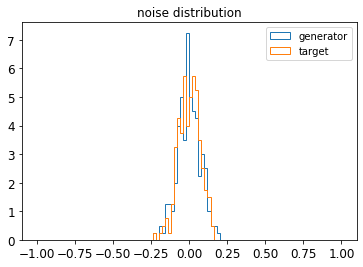

[0.693326294 -0.262924075]
counter 7600:
[0.684122562 -0.210685834]
Epoch: 7599 | disc_loss: 4.579968663165346e-05 | gen_loss: -9.146837328444235e-06
counter 7700:
[0.241561592 -0.395187616]
Epoch: 7699 | disc_loss: 4.521014489000663e-05 | gen_loss: -8.867481483321171e-06
counter 7800:
[0.713539064 -0.347390562]
Epoch: 7799 | disc_loss: 4.463329241843894e-05 | gen_loss: -8.607357813161798e-06
counter 7900:
[0.331930488 -0.143853143]
Epoch: 7899 | disc_loss: 4.407389496918768e-05 | gen_loss: -8.33083140605595e-06
counter 8000:
[0.511283159 -0.506346166]
Epoch: 7999 | disc_loss: 4.352748146629892e-05 | gen_loss: -8.062172128120437e-06


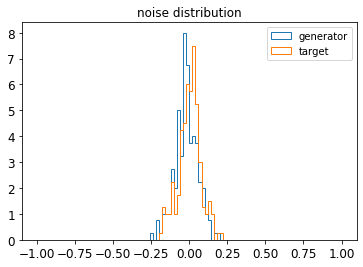

[0.443933278 -0.448839068]
counter 8100:
[0.2490412 -0.652270615]
Epoch: 8099 | disc_loss: 4.2995619878638536e-05 | gen_loss: -7.805618224665523e-06
counter 8200:
[0.597916663 -0.348936975]
Epoch: 8199 | disc_loss: 4.248056939104572e-05 | gen_loss: -7.382114745269064e-06
counter 8300:
[0.626306355 -0.41030854]
Epoch: 8299 | disc_loss: 4.197759335511364e-05 | gen_loss: -7.0009700721129775e-06
counter 8400:
[0.49321565 -0.311656237]
Epoch: 8399 | disc_loss: 4.14841779274866e-05 | gen_loss: -6.637510978180217e-06
counter 8500:
[0.57081461 -0.133443564]
Epoch: 8499 | disc_loss: 4.100225123693235e-05 | gen_loss: -6.354522611218272e-06


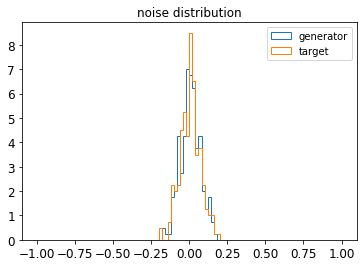

[0.469157785 -0.757890165]
counter 8600:
[0.461237043 -0.307201475]
Epoch: 8599 | disc_loss: 4.052818985655904e-05 | gen_loss: -6.040384960215306e-06
counter 8700:
[0.620176911 -0.512210608]
Epoch: 8699 | disc_loss: 4.00701210310217e-05 | gen_loss: -5.815705662826076e-06
counter 8800:
[0.485275298 -0.080414027]
Epoch: 8799 | disc_loss: 3.961914262617938e-05 | gen_loss: -5.5060572776710615e-06
counter 8900:
[0.509156525 -0.178850979]
Epoch: 8899 | disc_loss: 3.917998765246011e-05 | gen_loss: -5.203597993386211e-06
counter 9000:
[0.649376094 -0.323500514]
Epoch: 8999 | disc_loss: 3.875004767905921e-05 | gen_loss: -4.876079856330762e-06


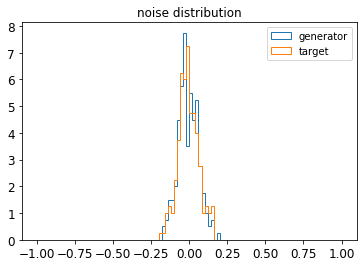

[0.69142 -0.407722503]
counter 9100:
[0.657709658 -0.463534892]
Epoch: 9099 | disc_loss: 3.8329373637679964e-05 | gen_loss: -4.661498678615317e-06
counter 9200:
[0.588625252 -0.701031089]
Epoch: 9199 | disc_loss: 3.7916401197435334e-05 | gen_loss: -4.410709152580239e-06
counter 9300:
[0.736422658 -0.291519761]
Epoch: 9299 | disc_loss: 3.751578333321959e-05 | gen_loss: -4.066363089805236e-06
counter 9400:
[0.328391552 -0.290144503]
Epoch: 9399 | disc_loss: 3.7120778870303184e-05 | gen_loss: -3.852965164696798e-06
counter 9500:
[0.681209385 -0.288987756]
Epoch: 9499 | disc_loss: 3.67344546248205e-05 | gen_loss: -3.4997831335203955e-06


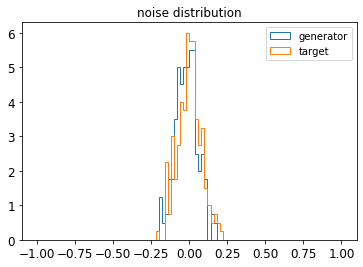

[0.275960058 -0.37877813]
counter 9600:
[0.308558673 -0.0590558201]
Epoch: 9599 | disc_loss: 3.635346729424782e-05 | gen_loss: -2.9984626053192187e-06
counter 9700:
[0.701813817 -0.389688969]
Epoch: 9699 | disc_loss: 3.5979392123408616e-05 | gen_loss: -2.6081345367856557e-06
counter 9800:
[0.627823174 -0.379213661]
Epoch: 9799 | disc_loss: 3.561468838597648e-05 | gen_loss: -2.136804596375441e-06
counter 9900:
[0.675303042 -0.285395592]
Epoch: 9899 | disc_loss: 3.525990177877247e-05 | gen_loss: -1.841533048718702e-06
counter 10000:
[0.63441503 -0.384547025]
Epoch: 9999 | disc_loss: 3.4910084650618955e-05 | gen_loss: -1.5274782754204352e-06
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Time for the training is 811.5212955474854 sec,
False
Time for the training is 811.5777077674866 sec,
CPU times: user 13min 38s, sys: 3.64 s, total: 13min 42s
Wall time: 13min 31s


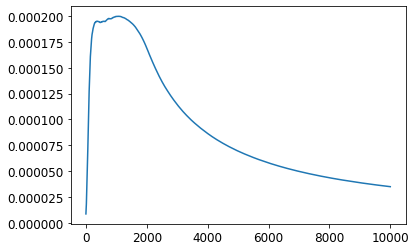

In [21]:
%%time

generator_optimizer, discriminator_optimizer = gan_optimizers(gen_learning_rate=gen_learning_rate, disc_learning_rate = disc_learning_rate)
start = time.time()
creating_and_train_gan(epochs= 3001,n_steps=5, batch_size =100, SNR_level = 7, n = n)
time_to_train_gan = time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))


# AE training

In [22]:
%%time

gan_decoder = get_gan_decoder(M)
gan_encoder = get_gan_encoder(M)



gan_AE = tf.keras.models.Sequential([gan_encoder,generator,gan_decoder])
data, test_data = random_sample(10000000), random_sample(10000)
start = time.time()
gan_AE.compile(optimizer=keras.optimizers.Nadam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=500,steps_per_epoch=400, epochs=10)
time_to_train_gan += time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))
gan_AE.summary()  

Train on 10000000 samples
Epoch 1/10
  196000/10000000 [..............................] - ETA: 1:47 - loss: 0.1564 - accuracy: 0.9485Time for the training is 25.63027334213257 sec,
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, None)              1922      
_________________________________________________________________
model (Model)                (None, 2)                 4622      
_________________________________________________________________
sequential_4 (Sequential)    (None, 16)                1680      
Total params: 8,224
Trainable params: 3,602
Non-trainable params: 4,622
_________________________________________________________________
CPU times: user 32 s, sys: 932 ms, total: 32.9 s
Wall time: 26 s


### Training MI

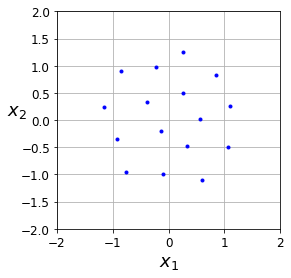

In [23]:
gan_encoder.trainable = False
gan_decoder.trainable = False

test_encoding(M,n)   


In [0]:
# test msg sequence for normal encoding
N_test = 500000
test_msg = np.random.randint(M, size=N_test)

### Comparison

In [25]:
gan_bber_data = gan_Test_AE(test_msg)
bber_data_rayleigh = Test_AE_rayleigh(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts
Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


time to train the AE Model with GAN 837.2079684734344


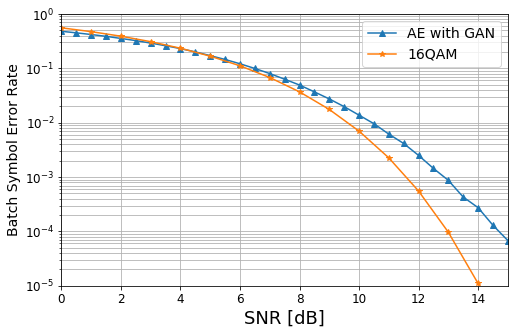

In [26]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], '^-')
plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '*-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['AE with GAN', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")
print('time to train the AE Model with GAN',time_to_train_gan)


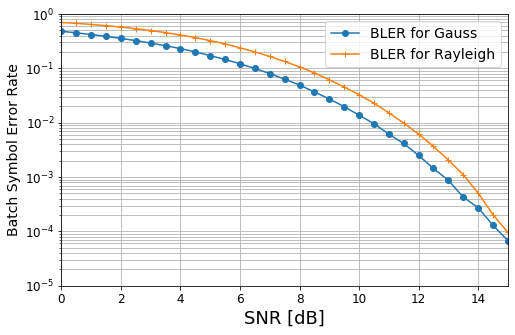

In [27]:
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], 'o-')
plt.semilogy(bber_data_rayleigh[0], bber_data_rayleigh[1], '+-')
#plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '^-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['BLER for Gauss','BLER for Rayleigh'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")